In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
from typing import List
import h5py
import io
from PIL import Image
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.categorical import Categorical

import pytorch_lightning as pl
import torchmetrics
import segmentation_models_pytorch as smp


#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import evidence_loss
import epipolar_geometry

import torch.nn.functional as F


from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import Resize

from pytransform3d.transform_manager import TransformManager

import uncertain_fusion

In [3]:
# CONSTANTS 

#CM_FILE_NAME = 'vkitti_cm.npy'
CM_FILE_NAME = 'vkitti_unet_cm.npy'


## Dataloader

In [4]:

class SequentialImageVirtualKittiDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        root: str, 
        mode: str = "train", 
        transforms = None):

        assert mode in {"train", "valid", "test"}
        
        self.mode = mode
        self.transforms = transforms

        self.files_directory = root
  
        self.data_column_names=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic']
        #if you want a subset of the data
        self.subset = ['15-deg-left', '15-deg-right', '30-deg-left', '30-deg-right','clone', 'fog']
        self.val_subset = ['morning', 'overcast', 'rain', 'sunset']
        
        #Filenames extracted as a pandas dataframe
        self.seq_filenames = self._read_split()  # read train/valid/test splits
        self.mask_colors = pd.read_csv(os.path.join(self.files_directory, 
                                               'colors.txt'), delimiter=' ')
        self.mask_colors['mask_label'] = self.mask_colors.index
        #Replacing the follwing
        '''
        [['Terrain',     0   1],
         ['Sky',         1   2],
         ['Tree',        2   3],
         ['Vegetation'   3   3],
         ['Building',    4   4],
         ['Road',        5   5],
         ['GuardRail',   6   0],
         ['TrafficSign', 7   0],
         ['TrafficLight',8   0],
         ['Pole',        9   0],
         ['Misc', ,      10  0],
         ['Truck',       11  6],
         ['Car', ,       12  6],
         ['Van',         13  6],
         ['Undefined',   14  0]]
        '''
        current_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
        replace_labels = [1,2,3,3,4,5,0,0,0,0, 0, 6, 6, 6, 0]
        self.mask_colors['mask_label'] =self.mask_colors['mask_label'].replace(current_labels, 
                                                                               replace_labels)
        print ("Total classes ", len(self.mask_colors['mask_label'].unique()))
        print ("Total classes ", (self.mask_colors['mask_label'].unique()))
        #Final classes are
        self.mask_colors = self.mask_colors.values.tolist()
        self.label_names = ['misc', 'Terrain', 'Sky', 'Tree', 'Building', 'Road', 'Vehicle']
      
    def __len__(self) -> int:
        return len(self.seq_filenames)
    
    @staticmethod
    def _give_rotation_translation(old_transformation_matrix,
                                 new_transformation_matrix):
        
        tm = TransformManager()
        tm.add_transform("world", "old_pose", old_transformation_matrix)
        tm.add_transform("world", "new_pose", new_transformation_matrix)
        old2new = tm.get_transform("old_pose", "new_pose")
        R = old2new[:3,:3]
        T = old2new[:3,3].reshape(3,1)
        return R, T
    
    def __getitem__(self, index: int) -> dict:

        len_sequence = len(self.seq_filenames[index])
        transformation_matrices = None
        sample = {}
        for idx, filename in enumerate(self.seq_filenames[index]):
            sidx = str(idx)
            #Reading image as numpy
            with h5py.File(filename, 'r') as data:
                
                sample['image'+sidx] = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['image'])))))
                sample['mask'+sidx] = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['mask'])))))         
                
                #Was geting a user warning that array is not writeable and pytroch needs writeable
                #sample['image'+sidx] = np.copy(sample['image'+sidx])
                #sample['mask'+sidx] = np.copy(sample['mask'+sidx])
                if (idx+1) < len_sequence: 
                    sample['depth'+sidx] = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['depth'])))))
                    #sample['depth'+sidx] = np.copy(sample['depth'+sidx])
                    
                if transformation_matrices is None:
                    transformation_matrices=np.array(data['extrinsic'])
                else:
                    new_transformation_matrix = np.array(data['extrinsic'])
                    r,t = self._give_rotation_translation(transformation_matrices,
                                                             new_transformation_matrix)
                    sample['rotation_'+str(idx-1)+'_to_'+str(idx)+'_camera_frame'] = r
                    sample['translation_'+str(idx-1)+'_to_'+str(idx)+'_camera_frame'] = t
                    transformation_matrices = new_transformation_matrix
                


            sample['mask'+sidx] = self._preprocess_mask(sample['mask'+sidx])

            #Applies transformation and converts to tensor
            if self.transforms is not None:            
                transformed = self.transforms(image=sample['image'+sidx], 
                                              mask=sample['mask'+sidx], 
                                              depth=sample['depth'+sidx] if (idx+1) < len_sequence  else None)

                sample['image'+sidx] = transformed['image']
                sample['mask'+sidx] = transformed['mask'].long()
                if (idx+1) < len_sequence:
                    sample['depth'+sidx] = transformed['depth']
        

        return sample
    
    def _preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        ''' 
        Convert RGB mask to single channel mask based on the color value
        provided in color.txt file 
        
        Parameters:
            mask: Numpy array mask of shape [height, width, 3]
            out: Numpy array of shape [height, width]
        '''
        preprocessed_mask = np.zeros(mask.shape[:2])
        for index, row in enumerate(self.mask_colors):
            # The columns of  mask_color dataframe is ['Terrain', r, g, b, mask_label]
            idx = np.all(mask == (row[1], row[2], row[3]), axis=-1) #
            preprocessed_mask[idx] = row[4]

        return preprocessed_mask

    def _read_split(self) -> list:
        ''' 
        Parses the virual kitti dataset and converts to a pandas dataframe
        
        Parameters:
            out: A list
        '''

        filenames = pd.read_csv(self.files_directory+'/virtual_kiti_file_naming.csv')
        if self.mode == "train":  # 90% for train
            filenames = filenames[filenames['scenario'].isin(self.subset)]
        elif self.mode == "valid":  # 10% for validation
            filenames = filenames[filenames['scenario'].isin(self.val_subset)]
        
        scene_folder_name = filenames['scene'].unique()
        scenario_folder_name = filenames['scenario'].unique()
        camera_folder_name = filenames['camera_number'].unique()
        frame_names = filenames['frame_number'].unique()
        
        #getting sequence of 2 frames here 
        #change here for 3 or n frames 
        seq_frame_names = [[i+n for n in range(0, 2, 1)] for i, x in enumerate(frame_names)] 
        
        #Runs loop and adds filenames
        seq_filenames = []
        for scene in scene_folder_name:
            for scenario in scenario_folder_name:
                for c in camera_folder_name:
                    for seq in seq_frame_names:
                        data_0 = scene+'_'+scenario+'_'+c+'_'+str(seq[0]).zfill(5)+'.h5'
                        data_1 = scene+'_'+scenario+'_'+c+'_'+str(seq[1]).zfill(5)+'.h5'

                        data_0 = os.path.join(root,data_0)
                        data_1 = os.path.join(root,data_1)
                        if os.path.exists(data_0) and os.path.exists(data_1):
                            seq_filenames.append([data_0, data_1])
                            
        print( "Found {:d} 2 single images sequences".format(len(seq_filenames)))
                            
        #if self.mode == "train":  # 90% for train
        #    seq_filenames_idx = np.random.choice(len(seq_filenames), int(0.6*len(seq_filenames)), replace=False)           
        #elif self.mode =="valid":
        #    seq_filenames_idx = np.random.choice(len(seq_filenames), int(0.4*len(seq_filenames)), replace=False)
        #    print (seq_filenames_idx)
        #else:
        #    seq_filenames_idx = []

        #print ("Selecting {:d} two image sequences for mode {:s}".format(len(seq_filenames_idx), self.mode))
        #seq_filenames = [e for i, e in enumerate(seq_filenames) if i in seq_filenames_idx]
        print ("Selecting {:d} two image sequences for mode {:s}".format(len(seq_filenames), self.mode))
        return seq_filenames



In [5]:
class Preprocess(torch.nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""
    def __init__(self, resize_shape=512) -> None:
        super().__init__()
        self.resize = Resize(size=(resize_shape,resize_shape))
        #self.crop = RandomCrop(size=(64,64), cropping_mode="slice")

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, 
                image: np.array, 
                mask: np.array,
                depth: np.array) -> Tensor:
        #x_tmp: np.ndarray = np.array(image)  # HxWxC
        x_out: Tensor = image_to_tensor(image, keepdim=True)  # CxHxW
        #x_out: Tensor = self.resize(x_out.float()).squeeze(dim=0)
        #x_tmp: np.ndarray = np.array(mask)  # HxWxC
        mask_out: Tensor = image_to_tensor(mask).squeeze(dim=0)
        #mask_out: Tensor = self.resize(mask_out.float()).squeeze(dim=0).squeeze(dim=0)
        
        if depth is not None:
            depth_out: Tensor = image_to_tensor(depth).squeeze(dim=0)
            #depth_out: Tensor = self.resize(depth_out.float()).squeeze(dim=0).squeeze(dim=0)
        else:
            depth_out = None
        
        return {'image':x_out.float() / 255.0, 'mask':mask_out.long(), 'depth':depth_out}

In [7]:
kornia_transform = Preprocess(resize_shape=64)
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/'

valid_dataset = SequentialImageVirtualKittiDataset(root, "valid", transforms=kornia_transform)

train_dataset = SequentialImageVirtualKittiDataset(root, "train", transforms=kornia_transform)

loaders = {
    "train": DataLoader(train_dataset, batch_size=5, shuffle=True, 
                        num_workers=int(16/2), persistent_workers=True, pin_memory=True), 
    "valid": DataLoader(valid_dataset, batch_size=5, shuffle=False, num_workers=int(16/2)),
}
print (len(train_dataset), len(valid_dataset))

Found 16968 2 single images sequences
Selecting 16968 two image sequences for mode valid
Total classes  7
Total classes  [1 2 3 4 5 0 6]
Found 25452 2 single images sequences
Selecting 25452 two image sequences for mode train
Total classes  7
Total classes  [1 2 3 4 5 0 6]
25452 16968


## Epipolar Propagation Testing

1. original  image size (375, 1242, 3)
2. Camera parameters matrix for original image 
(K[0,0] K[1,1] K[0,2] K[1,2]) -> (725.0087 725.0087 620.5 187 )
3. Scaling image to size (64, 64, 3)
yes, by different scales I guess: 375 -> 255 -> scale_y = ~0.68, 1242 -> 255 -> scale_x = 0.205 (edited) 
1:18
4. scale_y = 64/375 = 0.17066666666666666
5. scale_x =  64/1242 = 0.05152979066022544
6. k[0] = k[0] * 0.05152979066022544
7. k[1] = k[1] * 0.17066666666666666

In [14]:
IMG_SIZE = 256

In [15]:
old_k = np.array([[725.0087, 0, 620.5],
                   [0, 725.0087, 187],
                   [0, 0, 1]])

K = np.array([[725.0087*(IMG_SIZE/1242), 0, IMG_SIZE/2],
                   [0, 725.0087*(IMG_SIZE/375), IMG_SIZE/2],
                   [0, 0, 1]])

Kinv= np.linalg.inv(K)

print (K)
print (Kinv)

[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]


In [16]:
epipolar_propagation = epipolar_geometry.EpipolarPropagation(K, 
                                           Kinv, 
                                           IMG_SIZE, 
                                           IMG_SIZE, 
                                           fill_empty_with_ones=False)
epipolar_propagation.cuda()

cuda


EpipolarPropagation()

In [17]:
propagate_mask0 = epipolar_propagation(batch["mask0"].unsqueeze(dim=1), 
                                             batch['depth0']/100, 
                                             batch['translation_0_to_1_camera_frame'],
                                             batch['rotation_0_to_1_camera_frame'])

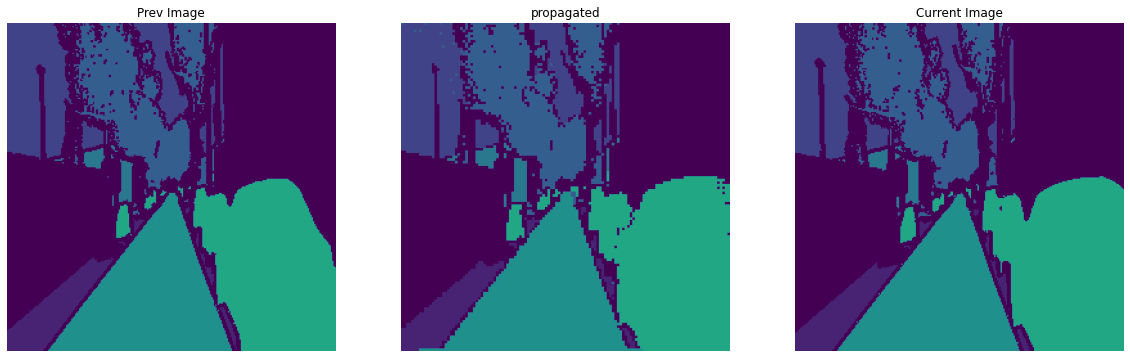

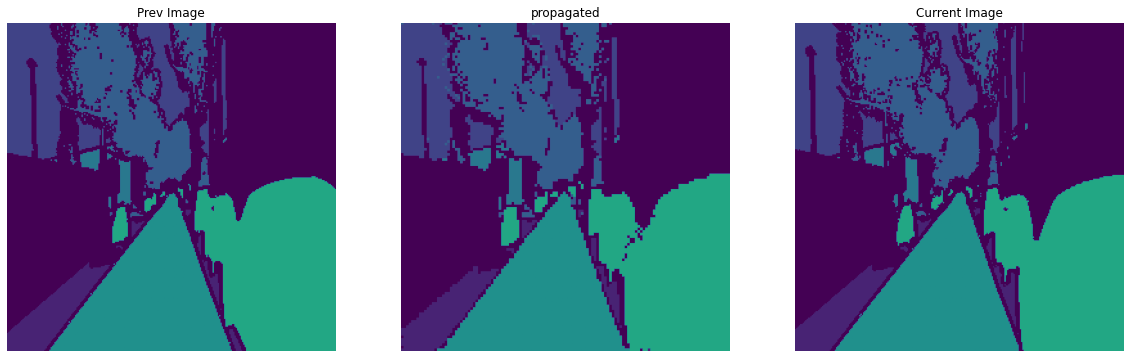

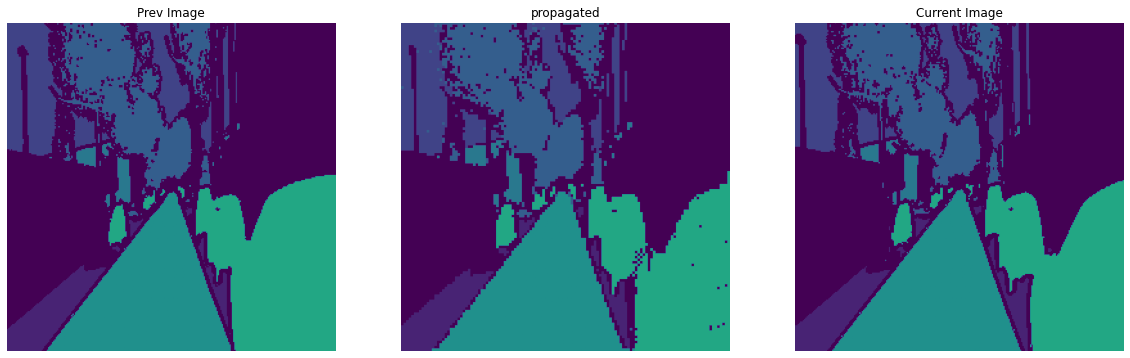

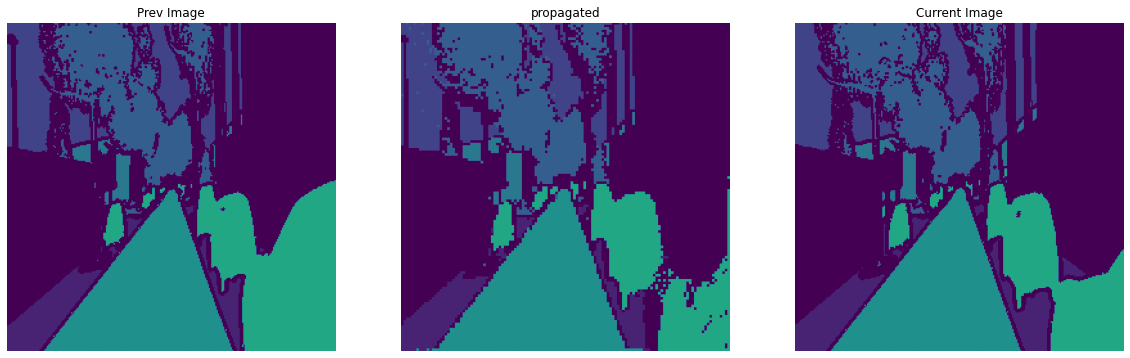

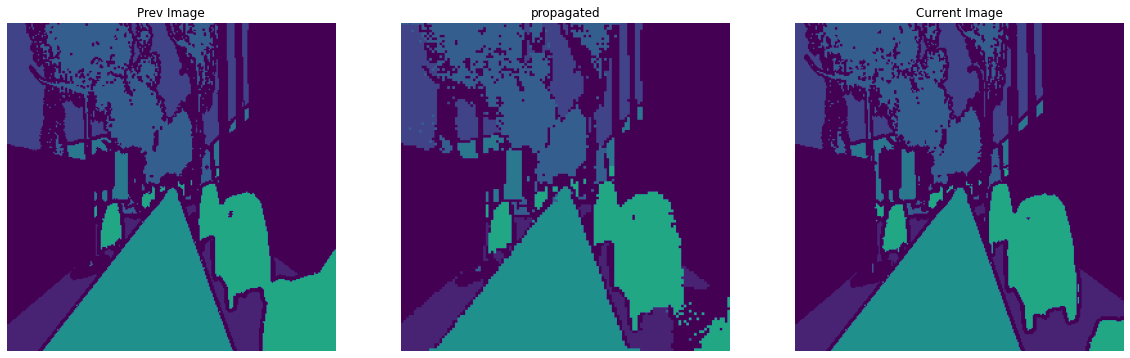

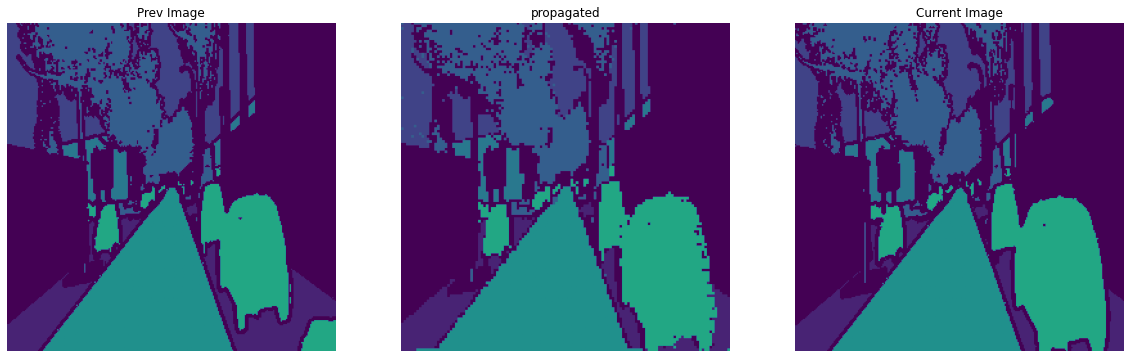

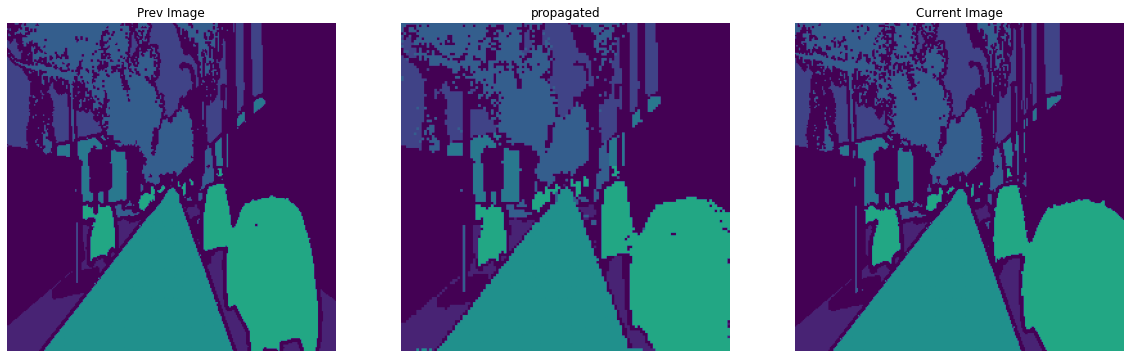

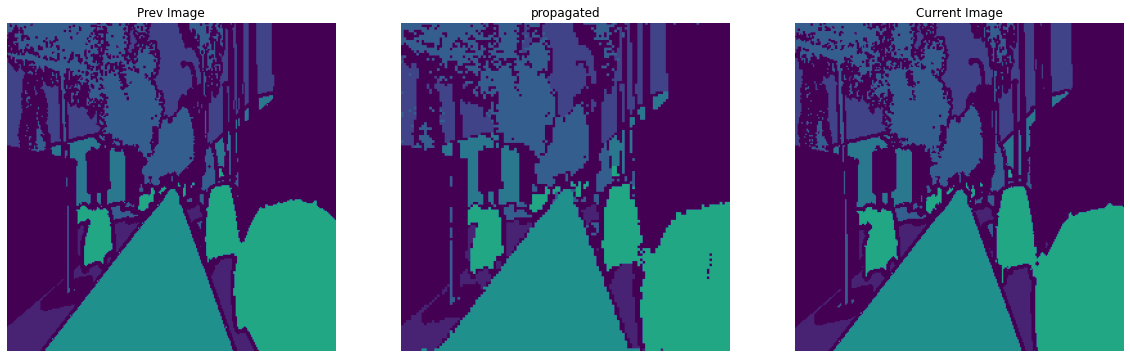

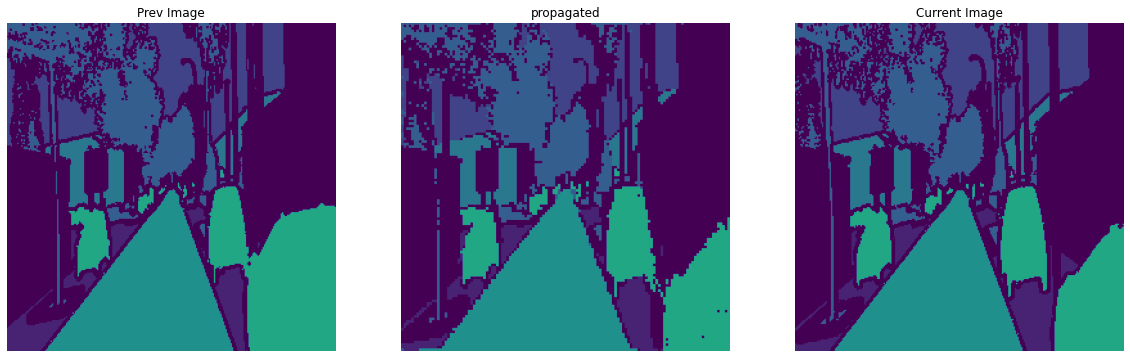

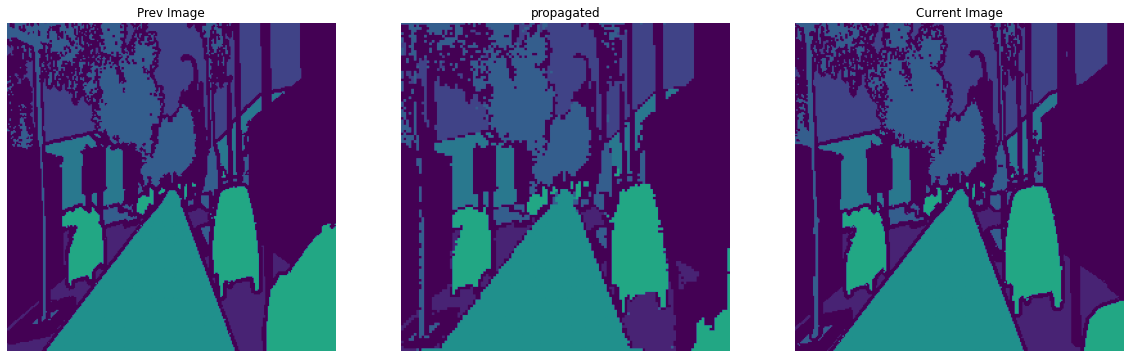

In [18]:
for image, nex_img, gt_mask in zip(batch["mask0"], batch["mask1"], propagate_mask0):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("Prev Image")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(nex_img.numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("Current Image")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    #plt.imshow(gt_mask.cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("propagated")
    plt.axis("off")

### Debug Epipolae

In [116]:
import torch
import torch.nn.functional as F


class EpipolarPropagation(torch.nn.Module):
    ''' Epipolar Propagation
    EpipolarPropagation propagates a batch tensor based on the depth 
    and camera parameters.
    Parameters:
        fill_empty_with_ones : The value to fill the empty tensor. 
    ASSUMPTION: Works on on square images because of the clamping
    TODO : Find a way of better clamping rather than magic number 511
    ToDo Remove the loop for filling
    TODO : Assert of intrinsic and image height . need to check datagenerator
    Args:
        K
        Kinv
        height
        width 
        fill_empty_with_ones
        min_depth (float, optional): value used to clamp ``depth``  for
            stability. Default: 0.1 in cm.
    
    
    '''
    def __init__(self, K, Kinv, height, width, fill_empty_with_ones=False, min_depth=0.1):
        super(EpipolarPropagation, self).__init__()
        
        assert K.ndim == 2
        assert Kinv.ndim == 2
        assert height == width #Onlt works for square images, update in dataloader
        
        self.fill_empty_with_ones = fill_empty_with_ones
        self.min_depth = min_depth
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(self.device )
        
        #self.K = torch.Tensor(K).float().to(self.device)
        # good
        self.register_buffer("K", torch.Tensor(K).float())
        self.register_buffer("Kinv", torch.Tensor(Kinv).float())

        #self.Kinv = torch.Tensor(Kinv).float().to(self.device)
        self.height = height
        self.width = width
        
        #checking if cmaera intrinsic is alligned with the image size
        #assert K[0,2]*2 == height
        #commeinting htis as intrinsix image size is 511 and actual image is 512 need to debug
        
        #Getting index of each pixel of image in [n,3, height*width] shape device=self.device
        #self.grid_x, self.grid_y = torch.meshgrid(torch.arange(height, device=self.device), 
        #                                torch.arange(width, device=self.device), indexing='ij')
        grid_x, grid_y = torch.meshgrid(torch.arange(height), 
                                        torch.arange(width), indexing='ij')      
        grid_x = torch.flatten(grid_x, start_dim=0)
        grid_y = torch.flatten(grid_y, start_dim=0)
        
        self.register_buffer("grid_x", grid_x) 
        self.register_buffer("grid_y", grid_y)
        ## Stacking to make the matrix 3 x points
        #self.index = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y))).float()
        self.register_buffer("index", torch.vstack((grid_x, grid_y, torch.ones_like(grid_y))).float())
        
    def forward(self, image, depth, T, R):
        assert torch.is_tensor(image) == True
        assert torch.is_tensor(depth) == True
        assert torch.is_tensor(T) == True
        assert torch.is_tensor(R) == True
        assert image.ndim == 4
        assert depth.ndim == 3
                
        #Getting depth and flatenning it and making it [n, 1, height*width] shape
        flattened_depth = torch.flatten(depth, start_dim=1)
        flattened_depth = torch.unsqueeze(flattened_depth, dim=1).float().to(self.device)

        #Getting Transformation and Rotation from previous frame
        T = T.float().to(self.device)
        R = R.float().to(self.device)
        
        # Entries of var must be non-negative
        if torch.any(flattened_depth < 0):
            raise ValueError("Depth has negative entry/entries")

        # Clamp for stability
        flattened_depth=torch.clamp(flattened_depth, min=self.min_depth)
        
        #Epipolar Geometry Equations
        x = torch.matmul(torch.matmul(torch.matmul(self.K, R), self.Kinv), self.index)
        if (torch.isnan(x).any()):
            raise ValueError("Matrix mutiplication K, R , Kinv and index contains Nan")      
        y = torch.matmul(self.K,torch.div(T, flattened_depth)) 
        if (torch.isnan(y).any()):
            raise ValueError("Matrix mutiplication K, T and depth  contains Nan") 
        
        #When adding the sum some values go nan replace them with zero
        transposed_index = x + y 
        transposed_index[transposed_index==0.0] = 0.0001
                
        ## Dividing Last column for each image
        transposed_index = torch.div(transposed_index, transposed_index[:,2,:].unsqueeze(1))
        
        if (torch.isnan(transposed_index).any()):
            print ("K ", self.K)
            print ("Kinv", self.Kinv)
            #print ("index", self.index)
            print ("depth ", torch.min(flattened_depth))
            x = torch.matmul(self.K,torch.div(T, flattened_depth))
            y =  torch.matmul(torch.matmul(torch.matmul(self.K, R), self.Kinv), self.index)
            z = torch.nan_to_num(x+y, nan=0.1)
            print ("x + y what ", z.min(), torch.isnan(z.view(-1)).sum() )
            print ("last row z ", z[:,2,:].min(), torch.isnan(z[:,2,:]).sum()) 
            z = torch.div(z, z[:,2,:].unsqueeze(1))
            idx = torch.isnan(z)
            print ("value of nan at x and y ", x[idx], y[idx])
            print ("after divide  row ", z.min(), torch.isnan(z).sum() ) 
            print ("transposed_index ", torch.min(transposed_index), torch.isnan(transposed_index.view(-1)).sum())

            raise ValueError("Transposed index contains Nan")
            
        ## Clamping index ,  imagesize subtracting 1
        transposed_index = torch.clamp(transposed_index, min=0, max=self.height-1).long() # 
        #Projecting pixels from previous frame based on the transposed index
        if self.fill_empty_with_ones:
            projected_tensor = torch.ones_like(image, device=self.device)
        else:
            projected_tensor = torch.zeros_like(image, device=self.device)

        image = image.to(self.device)
        #ToDo can this be done without for loop
        for i,p in enumerate(transposed_index):
            projected_tensor[i,:,p[0],p[1]] = image[i,:,self.grid_x, self.grid_y]

        projected_tensor = projected_tensor.float()
        #m = torch.nn.MaxPool2d(2)
        projected_tensor = F.max_pool2d(projected_tensor, kernel_size=2)

        projected_tensor = F.interpolate(projected_tensor, scale_factor=2 )
        
        return projected_tensor
    


In [147]:
torch.nan_to_num(torch.tensor(-1) + torch.tensor(1), nan=1)

tensor(0)

In [117]:
IMG_SIZE = 256
old_k = np.array([[725.0087, 0, 620.5],
                   [0, 725.0087, 187],
                   [0, 0, 1]])

K = np.array([[725.0087*(IMG_SIZE/1242), 0, IMG_SIZE/2],
                   [0, 725.0087*(IMG_SIZE/375), IMG_SIZE/2],
                   [0, 0, 1]])

Kinv= np.linalg.inv(K)

print (K)
print (Kinv)
epipolar_propagation = EpipolarPropagation(K, 
                                           Kinv, 
                                           IMG_SIZE, 
                                           IMG_SIZE, 
                                           fill_empty_with_ones=False)
epipolar_propagation.cuda()

[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
cuda


EpipolarPropagation()

In [35]:
print (batch['depth0'].size(), 256*256, torch.count_nonzero(1e-10+batch['depth0']))

torch.Size([1, 256, 256]) 65536 tensor(65536)


In [118]:
propagate_mask0 = epipolar_propagation(batch["mask0"].unsqueeze(dim=1), 
                                             1e-10+batch['depth0']/100, 
                                             batch['translation_0_to_1_camera_frame'],
                                             batch['rotation_0_to_1_camera_frame'])

In [119]:
torch.isnan(propagate_mask0).any()


tensor(False, device='cuda:0')

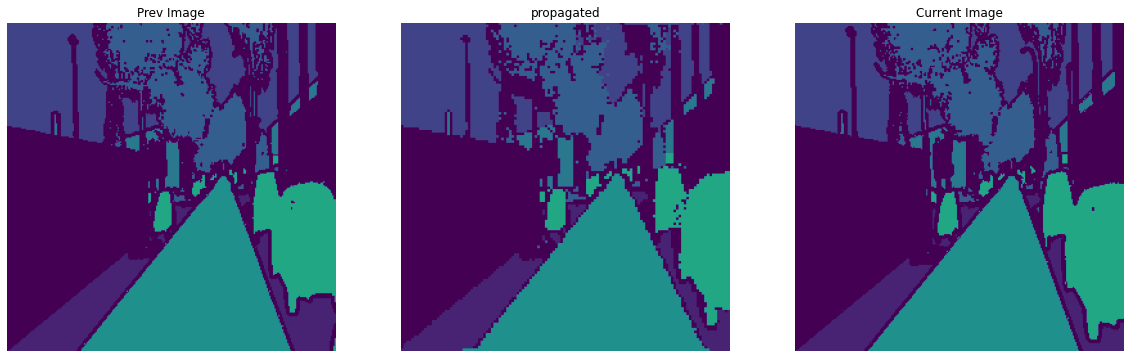

In [32]:
for image, nex_img, gt_mask in zip(batch["mask0"], batch["mask1"], propagate_mask0):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("Prev Image")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(nex_img.numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("Current Image")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    #plt.imshow(gt_mask.cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("propagated")
    plt.axis("off")

## Metrics

In [8]:
from torchmetrics import Metric
from torchmetrics.utilities import check_forward_full_state_property
class IoU(Metric):
    def __init__(self, n_classes, reduction="micro-imagewise"):
        super().__init__()
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="cat")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="cat")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="cat")
        self.add_state("tn", default=torch.tensor(0), dist_reduce_fx="cat")
        self.n_classes = n_classes
        assert reduction=="micro-imagewise" or reduction=="micro"
        self.reduction=reduction

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        assert preds.ndim == 4
        assert target.ndim == 4
        self.tp, self.fp, self.fn, self.tn = smp.metrics.get_stats(preds.long(),
                                               target.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)


    def compute(self):
       
        return smp.metrics.iou_score(self.tp, self.fp, self.fn, self.tn, reduction=self.reduction)


In [9]:

""" refer to https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/utils/metrics.py """
""" https://chowdera.com/2021/12/202112250822183610.html """

""" confusionMetric #  Be careful ： The horizontal line here represents the predicted value , 
The vertical represents the real value , Contrary to the previous Introduction  P\L P N P TP FP N FN TN """


class SegmentationMetric(torch.nn.Module):
    def __init__(self, numClass):
        super().__init__()
        self.numClass = numClass
        self.register_buffer("confusionMatrix", torch.zeros((self.numClass,) * 2))

    def pixelAccuracy(self):
        # return all class overall pixel accuracy  The proportion of correct pixels in the total pixels 
        # PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = torch.diag(self.confusionMatrix).sum() / self.confusionMatrix.sum()
        return acc

    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = torch.diag(self.confusionMatrix) / self.confusionMatrix.sum(dim=1)
        return classAcc  #  What is returned is a list value , Such as ：[0.90, 0.80, 0.96], Presentation category 1 2 3 Prediction accuracy of each category 

    def meanPixelAccuracy(self):
        """ Mean Pixel Accuracy(MPA, Average pixel accuracy )： yes PA A simple upgrade of , Calculate the proportion of correctly classified pixels in each class , Then find the average of all classes . :return: """
        classAcc = self.classPixelAccuracy()
        meanAcc = torch.nanmean(classAcc)  # np.nanmean  averaging ,nan I met with Nan type , Its value is 0
        return meanAcc  #  Returns a single value , Such as ：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 = 0.89

    def IntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = torch.diag(self.confusionMatrix)  #  Take the value of the diagonal element , Returns a list of 
        union = torch.sum(self.confusionMatrix, dim=1) + torch.sum(self.confusionMatrix, dim=0) - torch.diag(
            self.confusionMatrix)  # axis = 1 Represents the value of the confusion matrix row , Returns a list of ; axis = 0 Means to take the value of the confusion matrix column , Returns a list of 
        IoU = intersection / union  #  Returns a list of , Its value is... Of each category IoU
        return IoU

    def meanIntersectionOverUnion(self):
        mIoU = torch.nanmean(self.IntersectionOverUnion())  #  Find each category IoU The average of 
        return mIoU

    def genConfusionMatrix(self, imgPredict, imgLabel):  #
        """  Same as FCN in score.py Of fast_hist() function , Calculating the confusion matrix  :param imgPredict: :param imgLabel: :return:  Confusion matrix  """
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = torch.bincount(label, minlength=self.numClass ** 2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        # print(confusionMatrix)
        return confusionMatrix

    def Frequency_Weighted_Intersection_over_Union(self):
        """ FWIoU, Frequency to weight ratio : by MIoU A kind of promotion of , This method sets the weight for each class according to its frequency of occurrence . FWIOU = [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)] """
        freq = torch.sum(self.confusionMatrix, dim=1) / torch.sum(self.confusionMatrix)
        iu = torch.diag(self.confusionMatrix) / (
                torch.sum(self.confusionMatrix, dim=1) + torch.sum(self.confusionMatrix, dim=0) -
                torch.diag(self.confusionMatrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)  #  Get the confusion matrix 
        return self.confusionMatrix

    def reset(self):
        self.confusionMatrix = torch.zeros((self.numClass, self.numClass)).type_as(self.confusionMatrix)
        #self.register_buffer("confusionMatrix", torch.zeros((self.numClass,) * 2))

In [9]:
seg_metric = SegmentationMetric(numClass=7).cuda()
b = torch.randint(low=0, high=7, size=(3,1, 7, 7), device='cuda')
c = torch.randint(low=0, high=7, size=(3,1, 7, 7), device='cuda')
seg_metric.addBatch(b,c)
seg_metric.reset()
seg_metric.addBatch(b,c)


tensor([[1., 3., 4., 1., 5., 2., 2.],
        [3., 0., 6., 2., 5., 4., 3.],
        [4., 3., 1., 3., 2., 5., 1.],
        [1., 0., 1., 2., 1., 3., 4.],
        [2., 1., 6., 2., 2., 6., 3.],
        [4., 5., 6., 4., 1., 1., 2.],
        [4., 4., 6., 1., 4., 5., 6.]], device='cuda:0')

## Model Lightning

In [10]:

class SequenceVkitiModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, epipolar_propagation, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.n_classes = out_classes
                        
        self.epipolar_propagation = epipolar_propagation
        
        #self.conv_1d = torch.nn.Conv2d(in_channels=2*self.n_classes, out_channels=self.n_classes, kernel_size=1)
        self.val_0_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.val_1_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.ds_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.bayes_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.dampster_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.sum_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.mean_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        
        self.val_0_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.val_1_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.ds_fusion_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.bayes_fusion_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.sum_fusion_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.mean_fusion_seg_metric = SegmentationMetric(self.n_classes).cuda()        
        
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes, normalize='true')
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        
        self.DS_combine = uncertain_fusion.DempsterSchaferCombine(self.n_classes)
        self.mean_combine = uncertain_fusion.MeanUncertainty(self.n_classes)
        self.sum_combine = uncertain_fusion.SumUncertainty(self.n_classes)
        
        if os.path.isfile(CM_FILE_NAME): 
            cm = np.load(CM_FILE_NAME)
            self.bayesian = uncertain_fusion.EffectiveProbability(confusion_matrix = cm)
            #self.dampster = uncertain_fusion.EffectiveProbability(confusion_matrix = cm, fusion_type='dampster')
        else:
            self.bayesian = None
            #self.dampster = None
        
        self.metric_data = []
        
        self.fusion_methods = [self.DS_combine, self.mean_combine, self.sum_combine]#,self.bayesian, ]
        self.fusion_names = ['DS_combine', 'mean', 'sum']#'bayes',
        self.fusion_iou = [self.ds_fusion_iou, 
                                self.mean_fusion_iou,
                                self.sum_fusion_iou,
                                #self.bayes_fusion_iou,
                                #self.dampster_fusion_accuracy
                               ]
        self.fusion_seg_metric = [ self.ds_fusion_seg_metric, 
                                #   self.bayes_fusion_seg_metric,
                                   self.mean_fusion_seg_metric ,
                                   self.sum_fusion_seg_metric,
                                 ]
    def log_special(self, normalFusion, c_or_ic, name, t):
        mean=torch.mean(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median=torch.median(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        mean_prob=torch.mean(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median_prob=torch.median(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        uncertain=torch.mean(self.n_classes/torch.sum(t, dim=1, keepdim=True)).cpu().numpy().round(decimals=2)
        if mean > 1.0: #only dirchlet have greater than 1 
            dirchlet = torch.mean(Dirichlet(t).entropy()).cpu().numpy().round(decimals=2)
            categorical = torch.mean(Categorical(t/torch.sum(t, dim=1, keepdim=True)
                                                    ).entropy()).cpu().numpy().round(decimals=2)
            
        else:
            mean = 0.0
            median = 0.0
            dirchlet = 0.0
            uncertain = 0.0
            categorical = torch.mean(Categorical(t).entropy()).cpu().numpy().round(decimals=2)
            
        return [normalFusion, c_or_ic, name, mean, median, mean_prob, 
                median_prob, uncertain, dirchlet, categorical]

    def single_batch_forward(self, image):
        mask = self.model(image)
        return mask
    
    def forward(self, batch):
        logits_mask0 = self.single_batch_forward(batch["image0"])
        logits_mask0= F.relu(logits_mask0) + 1  #ToDO shoudl we do relu and propagate or just propagate
        
        propagate_mask0 = self.epipolar_propagation(logits_mask0, 
                                                     batch['depth0']/100,
                                                     batch['translation_0_to_1_camera_frame'],
                                                     batch['rotation_0_to_1_camera_frame'])
        
        logits_mask1 = self.single_batch_forward(batch["image1"])
        logits_mask1 = F.relu(logits_mask1) + 1
        
        return logits_mask0, propagate_mask0, logits_mask1
    
        
    def shared_step(self, batch, stage):
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert batch["image0"].ndim == 4
        
        bs, num_channels, height, width = batch["image0"].size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        assert height % 32 == 0 and width % 32 == 0

        batch["mask0"] = batch["mask0"].unsqueeze(dim=1)
        batch["mask1"] = batch["mask1"].unsqueeze(dim=1)
        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert batch["mask0"].ndim == 4
        assert batch["mask1"].ndim == 4
        
        logits_mask0, propagate_mask0, logits_mask1 = self.forward(batch)
        
        self.val_0_iou.update(logits_mask0.argmax( dim=1, keepdim=True),batch["mask0"])
        #print ("shared ", batch["mask0"].device, logits_mask0.device, self.val_0_seg_metric.confusionMatrix.device )
        self.val_0_seg_metric.addBatch(logits_mask0.argmax( dim=1, keepdim=True),batch["mask0"])
        self.log("val_0_iou", self.val_0_iou, prog_bar=True)
        self.val_1_iou.update(logits_mask1.argmax( dim=1, keepdim=True),batch["mask1"])
        self.val_1_seg_metric.addBatch(logits_mask1.argmax( dim=1, keepdim=True),batch["mask1"])
        self.log("val_1_iou", self.val_1_iou, prog_bar=True)
        
        for fusion, name, iou, seg_metric in zip(self.fusion_methods, 
                                                 self.fusion_names, 
                                                 self.fusion_iou,
                                                 self.fusion_seg_metric):
         
            #fusion_out = fusion(y_hat, yflip_hat)
            #print (' propagate_mask0  ', torch.isnan(propagate_mask0).any())
            #print (propagate_mask0.sum(dim=1, keepdim=True))
            #sump = propagate_mask0.sum(dim=1, keepdim=True)
            #print ("sump ", torch.numel(f)-torch.count_nonzero(f))
            fusion_out = fusion(propagate_mask0, logits_mask1)
            fusion_out = fusion_out.to(self.device)
            
            iou.update(fusion_out.argmax( dim=1, keepdim=True), batch["mask1"])
            seg_metric.addBatch(fusion_out.argmax( dim=1, keepdim=True), batch["mask1"])
            self.log(name+"_fusion", iou, prog_bar=True)
            
      

    def shared_epoch_end(self, outputs, stage):
        if "train" == stage:
            pass
        elif "valid"== stage:
            self.log("val_0"+"_pixelAccuracy", 
                         self.val_0_seg_metric.pixelAccuracy(), prog_bar=False)
            self.log("val_0"+"_meanIoU", 
                         self.val_0_seg_metric.meanIntersectionOverUnion(), prog_bar=False)
            self.log("val_0"+"_FrequencyIoU", 
                         self.val_0_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=False)
            self.log("val_1"+"_pixelAccuracy", 
                         self.val_1_seg_metric.pixelAccuracy(), prog_bar=False)
            self.log("val_1"+"_meanIoU", 
                         self.val_1_seg_metric.meanIntersectionOverUnion(), prog_bar=False)
            self.log("val_1"+"_FrequencyIoU", 
                         self.val_0_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=False)
            self.val_0_seg_metric.reset()
            self.val_1_seg_metric.reset()
            
            for seg_metric, fusion_name in zip(self.fusion_seg_metric, self.fusion_names):
                self.log(fusion_name+"_pixelAccuracy", 
                         seg_metric.pixelAccuracy(), prog_bar=False)
                self.log(fusion_name+"_meanIoU", 
                         seg_metric.meanIntersectionOverUnion(), prog_bar=False)
                self.log(fusion_name+"_FrequencyIoU", 
                         seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=False)

                seg_metric.reset()
        return
       

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):    
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [12]:
IMG_SIZE = 256
old_k = np.array([[725.0087, 0, 620.5],
                   [0, 725.0087, 187],
                   [0, 0, 1]])

K = np.array([[725.0087*(IMG_SIZE/1242), 0, IMG_SIZE/2],
                   [0, 725.0087*(IMG_SIZE/375), IMG_SIZE/2],
                   [0, 0, 1]])

Kinv= np.linalg.inv(K)

print (K)
print (Kinv)

print (K)
print (Kinv)
epipolar_propagation = epipolar_geometry.EpipolarPropagation(K, 
                                           Kinv, 
                                           IMG_SIZE, 
                                           IMG_SIZE, 
                                           fill_empty_with_ones=True)
epipolar_propagation.cuda()
model = SequenceVkitiModel("FPN", 
                            "timm-mobilenetv3_small_minimal_100", 
                            in_channels=3, 
                            out_classes=7,
                            epipolar_propagation=epipolar_propagation
                           )


#model.model = torch.load('vkitti_mobilenetv3_244s_10epoch_77a.pt')
#model.model = torch.load('vkitti_unet_50epoch_86a.pt')
model.model = torch.load('vkitti_unet_20epoch_78a.pt')
model.model = torch.load('/home/deebuls/Documents/phd/blender-dataset/multi-view-fusion-initial/vkitti_cluster_trained.pt')

[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
cuda
Initialized fusion type :  bayes


In [13]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=1,
    #callbacks=[pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-2)],
    #auto_lr_find=True,
    #profiler="simple",
    #precision=16,
    check_val_every_n_epoch=5
)
trainer.validate(
    model, 
    dataloaders=loaders['valid'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

/tmp/ipykernel_16393/3924905983.py:78: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'JpegImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  sample['image'+sidx] = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['image'])))))
/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Debug Fusion

fuse shape  torch.Size([5, 7, 256, 256])
uncertainty shape  torch.Size([5, 1, 256, 256])
torch.Size([5, 7, 256, 256])
logits_mask1  tensor(868.4127, device='cuda:0') tensor(2., device='cuda:0') tensor(10.7776, device='cuda:0')
uncertainty  tensor(0.3182, device='cuda:0') tensor(7.7141e-05, device='cuda:0')
fuse tensor(90723.8828, device='cuda:0') tensor(3.1429, device='cuda:0') tensor(207.5536, device='cuda:0')


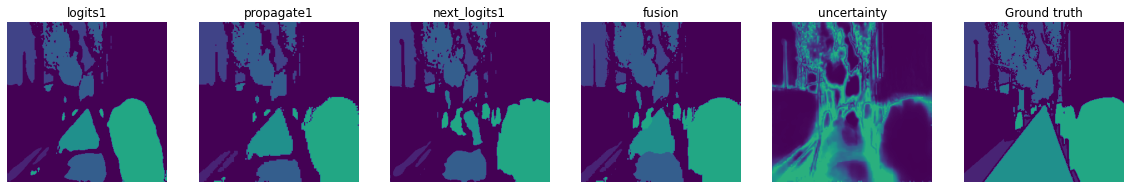

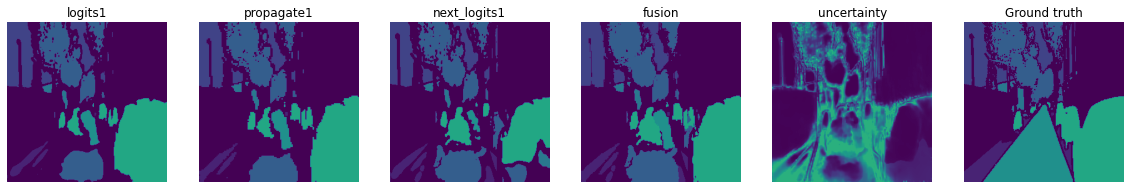

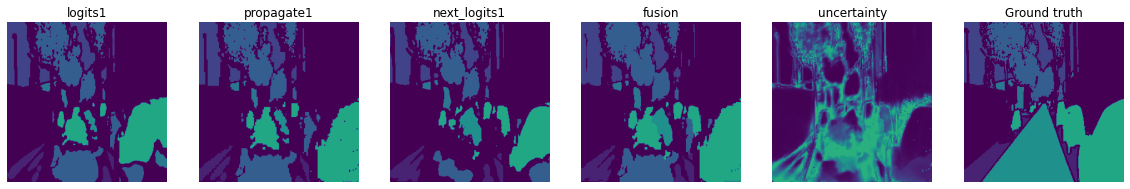

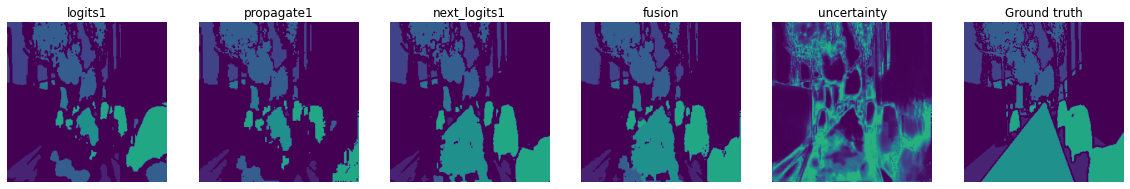

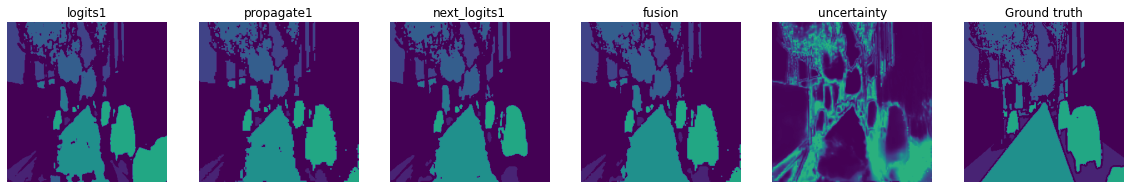

In [127]:
%matplotlib inline
DS_combine = uncertain_fusion.DempsterSchaferCombine(7)
sum_fusion = uncertain_fusion.SumUncertainty(7)
batch = next(iter(loaders['valid']))
bs, num_channels, height, width = batch["image0"].size()
with torch.no_grad():
    model.eval()
    model.cuda()
    batch['image0'] = batch['image0'].cuda()
    batch['image1'] = batch['image1'].cuda()
    logits_mask0, propagate_mask0, logits_mask1 = model(batch)
    logits_mask0 = F.relu(logits_mask0) +1
    propagate_mask0= F.relu(propagate_mask0) +1
    logits_mask1 = F.relu(logits_mask1) +1
    fuse = DS_combine(propagate_mask0, logits_mask1.to('cuda'))
    
    uncertainty = 7 / torch.sum(fuse, dim=1, keepdim=True)
    print ("fuse shape ", fuse.shape)
    print ("uncertainty shape ", uncertainty.shape)
    print (fuse.shape)
    #fuse = fuse.permute(0,3,1,2)
    #uncertainty = uncertainty.reshape(bs, height, width)

print ('logits_mask1 ', logits_mask1.max(), logits_mask1.min(), logits_mask1.mean())
print ('uncertainty ', uncertainty.max(), uncertainty.min())
print ('fuse', fuse.max(), fuse.min(), fuse.mean())
for logits1, propagate1, next_logits1, f, u, gt_mask in zip(torch.argmax(logits_mask0, dim=1, keepdim=True), 
                                   torch.argmax(propagate_mask0, dim=1, keepdim=True), 
                                   torch.argmax(logits_mask1, dim=1, keepdim=True),
                                   torch.argmax(fuse, dim=1, keepdim=True),   
                                    uncertainty,
                                   batch['mask1']):

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 6, 1)
    plt.imshow(logits1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("logits1")
    plt.axis("off")

    plt.subplot(1, 6, 6)
    plt.imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 6, 2)
    plt.imshow(propagate1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("propagate1")
    plt.axis("off")
  
    plt.subplot(1, 6, 3)
    plt.imshow(next_logits1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("next_logits1")
    plt.axis("off")
    
    plt.subplot(1, 6, 4)
    plt.imshow(f.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("fusion")
    plt.axis("off")
    
    plt.subplot(1, 6, 5)
    plt.imshow(u.detach().cpu().numpy().squeeze(), vmin=0, vmax=0.5) # just squeeze classes dim, because we have only one class
    plt.title("uncertainty")
    plt.axis("off")
  
    #plt.savefig('result.png')
    plt.show()
    
del batch, logits_mask0, propagate_mask0, logits_mask1 , fuse, uncertainty

## Debug epipolar propagate with logits

In [114]:
import uncertain_fusion
DS_combine = uncertain_fusion.DempsterSchaferCombine(7)


alpha 1 77 219  tensor([97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
alpha 2 77 219  tensor([97.8697,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
alpha 1 permute tensor([97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
alpha 2 permute  tensor([97.8697,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
19931
alpha 1 1*256*77 + 219  tensor([97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
alpha 2 1*256*77 + 219 tensor([97.8697,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
final 77 219  tensor([1526.3328,    3.1429,    3.1429,    3.1429,    3.1429,    3.1429,
           3.1429], device='cuda:0')
propagate_mask0  tensor(729.3896, device='cuda:0') tensor(2., device='cuda:0') tensor(10.9133, device='cuda:0')
logits_mask1  tensor(868.4127, device='cuda:0') tensor(2., device='cu

<IPython.core.display.Javascript object>


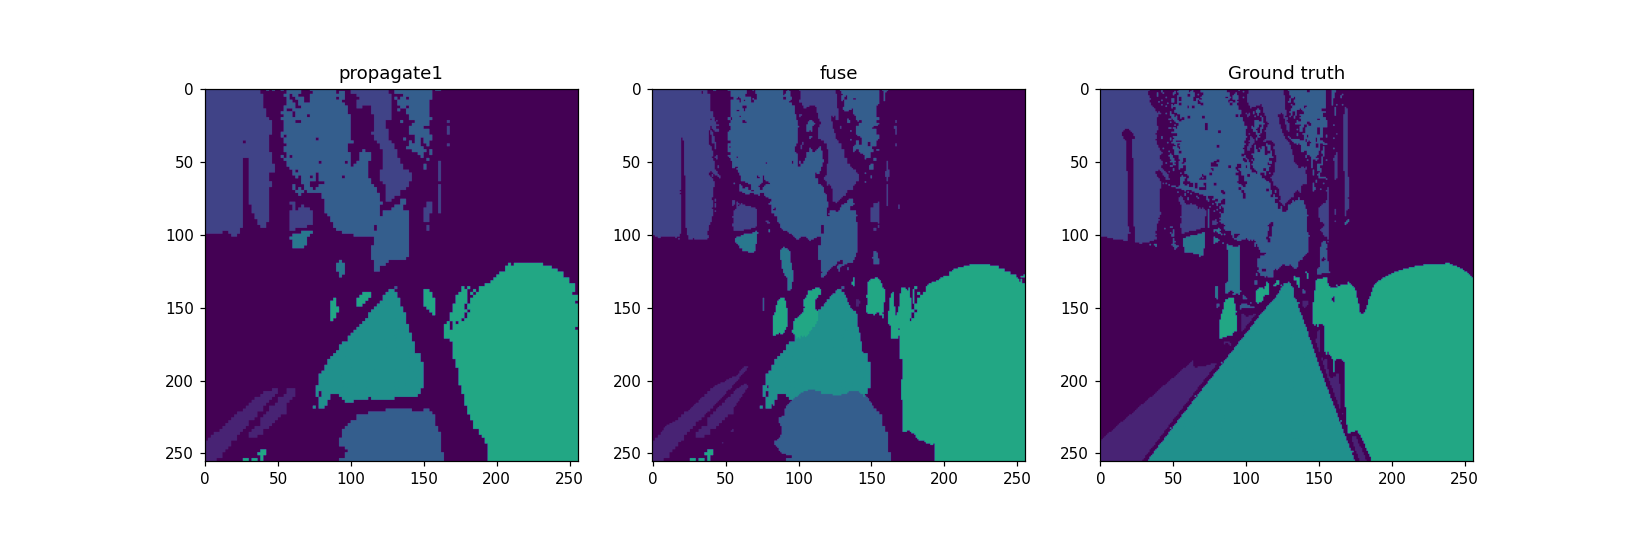

In [115]:
%matplotlib notebook
batch = next(iter(loaders['valid']))
bs, num_channels, height, width = batch["image0"].size()
with torch.no_grad():
    model.eval()
    model.cuda()
    batch['image0'] = batch['image0'].cuda()
    batch['image1'] = batch['image1'].cuda()
    logits_mask0, propagate_mask0, logits_mask1 = model(batch)
    logits_mask0 = F.relu(logits_mask0) +1
    propagate_mask0= F.relu(propagate_mask0) +1
    logits_mask1 = F.relu(logits_mask1) +1
    fuse = DS_combine(propagate_mask0, logits_mask1.to('cuda'))
    
print ('propagate_mask0 ', propagate_mask0.max(), propagate_mask0.min(), propagate_mask0.mean())
print ('logits_mask1 ', logits_mask1.max(), logits_mask1.min(), logits_mask1.mean())
print ('fuse ', fuse.max(), fuse.min(), fuse.mean())

for gt_mask, propagate1, f in zip(batch['mask1'], 
                              torch.argmax(propagate_mask0, dim=1, keepdim=True),
                              torch.argmax(fuse, dim=1, keepdim=True),):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(propagate1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("propagate1")
    #plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(f.detach().cpu().numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("fuse")
    #plt.axis("off")
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    #plt.axis("off")
    
    break
    
    
    
    

In [52]:
# onfident road pixel 121 164 gives correct 5 label
print (propagate_mask0[0,:, 164, 121])
print (logits_mask1[0,:, 164, 121])
print (fuse[0,:, 164, 121])

tensor([  2.0000,   2.0000,   2.0000,   2.0000,   2.0000, 175.7790,   2.0000],
       device='cuda:0')
tensor([2., 2., 2., 2., 2., 2., 2.], device='cuda:0')
tensor([  3.1429,   3.1429,   3.1429,   3.1429,   3.1429, 201.7474,   3.1429],
       device='cuda:0')


In [53]:
# onfident road pixel 202 188 gives correct 6 label
print (propagate_mask0[0,:, 188, 202])
print (logits_mask1[0,:, 188, 202])
print (fuse[0,:, 188, 202])

tensor([  2.0000,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000, 106.6825],
       device='cuda:0')
tensor([  2.0000,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000, 129.2089],
       device='cuda:0')
tensor([  3.1429,   3.1429,   3.1429,   3.1429,   3.1429,   3.1429, 122.7800],
       device='cuda:0')


In [75]:
for i in range(75, 80, 1):
    #the non confident region with 220, 76 , true value is 0
    #print (propagate_mask0[0,:, 78, 220])
    #print (logits_mask1[0,:, 78, 220])
    print (i, propagate_mask0[0,:, i, 219])
    print (i, logits_mask1[0,:, i, 219])
    print (i, fuse[0,:, i, 219])
    print ('-------')

75 tensor([100.7734,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000],
       device='cuda:0')
75 tensor([97.0415,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
75 tensor([116.0267,   3.1429,   3.1429, 153.1531, 259.6408, 343.9754, 410.8111],
       device='cuda:0')
-------
76 tensor([97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
76 tensor([96.4871,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
76 tensor([112.0196,   3.1429,   3.1429, 120.4250, 201.5017, 288.2082, 370.3826],
       device='cuda:0')
-------
77 tensor([97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
77 tensor([97.8697,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
77 tensor([112.0196,   3.1429,   3.1429, 119.8762, 201.0188, 297.5600, 400.1581],
       device='cuda:0')
-------
78 tensor([93.2280,  2.0000,  2.0000,  2.0000,  2.0000,  

In [61]:

#the non confident region with 220, 77 nerby pixel , true value is 0
print (propagate_mask0[0,:, 77, 219])
print (logits_mask1[0,:, 77, 219])
print (fuse[0,:, 77, 219])

tensor([97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
tensor([97.8697,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
       device='cuda:0')
tensor([112.0196,   3.1429,   3.1429, 119.8762, 201.0188, 297.5600, 400.1581],
       device='cuda:0')


In [63]:
x = torch.tensor([[97.2672,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000]])
y = torch.tensor([[97.8697,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000]])
DS_combine(x,y)

tensor([[1526.3333,    3.1429,    3.1429,    3.1429,    3.1429,    3.1429,
            3.1429]])

In [106]:
x = torch.arange(36).reshape(2,2,3,3) 
print(x[0,:, 1, 1])
print(x[1,:, 1, 1])

x = x.permute(0,2,3,1)
x = x.reshape(-1,2)
#want 0 batch 1 ,1, 1
print (x[4])
print (x[14])

print (0*3*3 + 3*1 + 1)
print (1*3*3 + 3*1 + 1)


tensor([ 4, 13])
tensor([22, 31])
tensor([ 4, 13])
tensor([23, 32])
5
14


[## Sample code

In [2]:
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/'

filenames = pd.read_csv(root+'/virtual_kiti_file_naming.csv')

In [3]:
filenames

,Unnamed: 0,scene,scenario,camera_number,frame_number,extrinsic
0,0,Scene01,15-deg-left,Camera_0,0,"[-0.008019686, 0.07217909, -0.9973595, 7.49445..."
1,1,Scene01,15-deg-left,Camera_0,1,"[-0.007779241, 0.0730738, -0.9972962, 7.283874..."
2,2,Scene01,15-deg-left,Camera_0,2,"[-0.008015394, 0.06971319, -0.9975349, 6.62668..."
3,3,Scene01,15-deg-left,Camera_0,3,"[-0.008151174, 0.06922305, -0.997568, 6.289214..."
4,4,Scene01,15-deg-left,Camera_0,4,"[-0.007937193, 0.06872611, -0.9976041, 5.91949..."
...,...,...,...,...,...,...
42515,42515,Scene20,sunset,Camera_1,832,"[-0.7014188, -0.01358945, -0.7126198, -111.951..."
42516,42516,Scene20,sunset,Camera_1,833,"[-0.7014475, -0.01355444, -0.7125923, -111.909..."
42517,42517,Scene20,sunset,Camera_1,834,"[-0.7014322, -0.01353448, -0.712608, -111.9159..."
42518,42518,Scene20,sunset,Camera_1,835,"[-0.7014487, -0.01356346, -0.7125909, -111.904..."


In [15]:
  
scene_folder_name = filenames['scene'].unique()
scenario_folder_name = filenames['scenario'].unique()
camera_folder_name = filenames['camera_number'].unique()
frame_names = filenames['frame_number'].unique()


In [16]:
max(frame_names)

836

In [17]:
seq_frame_names = [[i+n for n in range(2)] for i, x in enumerate(frame_names)] 

In [23]:
seq_filenames = []
for scene in scene_folder_name:
    for scenario in scenario_folder_name:
        for c in camera_folder_name:
            for seq in seq_frame_names:
                data_0 = scene+'_'+scenario+'_'+c+'_'+str(seq[0]).zfill(5)+'.h5'
                data_1 = scene+'_'+scenario+'_'+c+'_'+str(seq[1]).zfill(5)+'.h5'
                
                data_0 = os.path.join(root,data_0)
                data_1 = os.path.join(root,data_1)
                #print (data_0, data_1)
                if os.path.exists(data_0) and os.path.exists(data_1):
                    #print(data_0)
                    seq_filenames.append([data_0, data_1])
                    
                

In [24]:
len(seq_filenames)

42420

In [30]:
#Randomly selecting some filenames without replacement
x = np.random.choice(len(seq_filenames), 3, replace=False)
elements = [e for i, e in enumerate(seq_filenames) if i in x]
elements

[['/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_30-deg-left_Camera_0_00077.h5',
  '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_30-deg-left_Camera_0_00078.h5'],
 ['/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene20_30-deg-left_Camera_0_00267.h5',
  '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene20_30-deg-left_Camera_0_00268.h5'],
 ['/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene20_sunset_Camera_0_00021.h5',
  '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene20_sunset_Camera_0_00022.h5']]